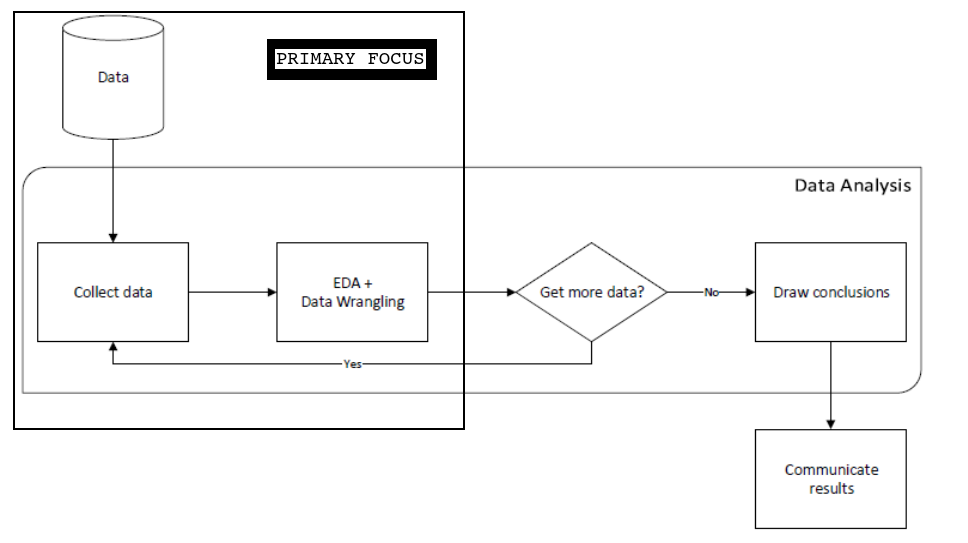

In [8]:
from IPython.display import Image
img1 = '/home/uddipan/Desktop/python/DA_Course/images/data_science_pipeline.png'
Image(filename=img1)

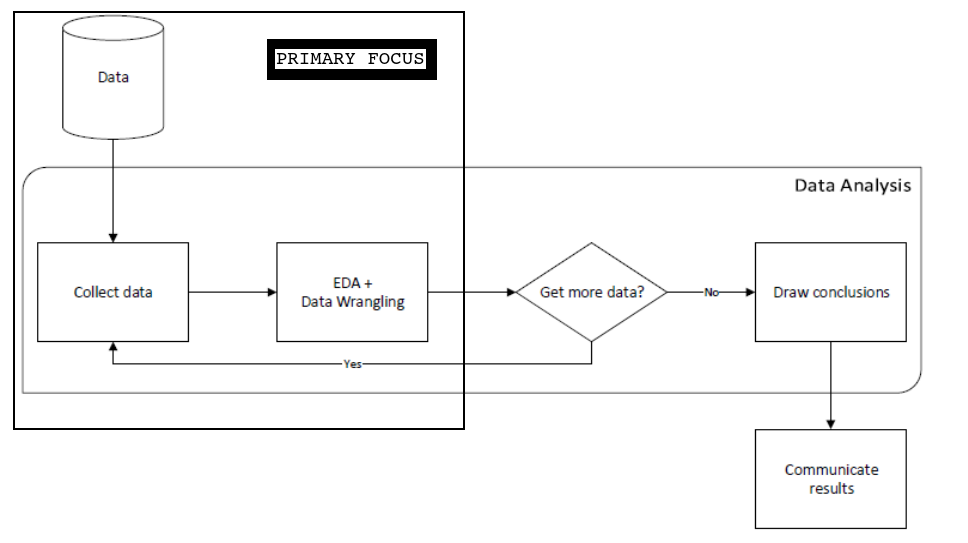

# Pandas Data Structures Overview
In this section, we will discuss the `Series`, `Index`, and `DataFrame` classes. To do so, we will read in a snippet of the CSV file we will work with later. Don't worry about that part yet, though.

## About the Data
In this notebook, we will be working with 5 rows from the earthquake data collected over September 18, 2018 - October 13, 2018 (obtained from the US Geological Survey (USGS) using the [USGS API](https://earthquake.usgs.gov/fdsnws/event/1/))

## Working with NumPy Arrays
Let's read in a short CSV file (using `numpy`) for some sample data. 

In [9]:
import numpy as np

data = np.genfromtxt(
    'data/example_data.csv', delimiter=';', 
    names=True, dtype=None, encoding='UTF'
)
data

array([('2018-10-13 11:10:23.560', '262km NW of Ozernovskiy, Russia', 'mww', 6.7, 'green', 1),
       ('2018-10-13 04:34:15.580', '25km E of Bitung, Indonesia', 'mww', 5.2, 'green', 0),
       ('2018-10-13 00:13:46.220', '42km WNW of Sola, Vanuatu', 'mww', 5.7, 'green', 0),
       ('2018-10-12 21:09:49.240', '13km E of Nueva Concepcion, Guatemala', 'mww', 5.7, 'green', 0),
       ('2018-10-12 02:52:03.620', '128km SE of Kimbe, Papua New Guinea', 'mww', 5.6, 'green', 1)],
      dtype=[('time', '<U23'), ('place', '<U37'), ('magType', '<U3'), ('mag', '<f8'), ('alert', '<U5'), ('tsunami', '<i8')])

We can find the dimensions with the `shape` attribute:

In [10]:
data.shape

(5,)

We can find the data types with the `dtype` attribute:

In [11]:
data.dtype

dtype([('time', '<U23'), ('place', '<U37'), ('magType', '<U3'), ('mag', '<f8'), ('alert', '<U5'), ('tsunami', '<i8')])

Each of the entries in the array is a row from the CSV file. NumPy arrays contain a single data type (unlike lists, which allow mixed types); this allows for fast, vectorized operations. When we read in the data, we got an array of `numpy.void` objects, which are created to store flexible types. This is because NumPy has to store several different data types per row: four strings, a float, and an integer. This means we can't take advantage of the performance improvements NumPy provides for single data type objects.

Say we want to find the maximum magnitude&mdash;we can use a **[list comprehension](https://www.python.org/dev/peps/pep-0202/)** to select the third index of each row, which is represented as a `numpy.void` object. This makes a list, meaning that we can take the maximum using the `max()` function:

In [14]:
data

array([('2018-10-13 11:10:23.560', '262km NW of Ozernovskiy, Russia', 'mww', 6.7, 'green', 1),
       ('2018-10-13 04:34:15.580', '25km E of Bitung, Indonesia', 'mww', 5.2, 'green', 0),
       ('2018-10-13 00:13:46.220', '42km WNW of Sola, Vanuatu', 'mww', 5.7, 'green', 0),
       ('2018-10-12 21:09:49.240', '13km E of Nueva Concepcion, Guatemala', 'mww', 5.7, 'green', 0),
       ('2018-10-12 02:52:03.620', '128km SE of Kimbe, Papua New Guinea', 'mww', 5.6, 'green', 1)],
      dtype=[('time', '<U23'), ('place', '<U37'), ('magType', '<U3'), ('mag', '<f8'), ('alert', '<U5'), ('tsunami', '<i8')])

In [19]:
data[0][3]
max([row[3] for row in data])

6.7

In [13]:
%%timeit
max([row[3] for row in data])

3.82 µs ± 57.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


If we, instead, create a NumPy array for each column, this operation is much easier (and more efficient) to perform. We can use a **[dictionary comprehension](https://www.python.org/dev/peps/pep-0274/)** to make a dictionary where the keys are the column names and the values are NumPy arrays of the data:

In [20]:
array_dict = {
    col: np.array([row[i] for row in data])
    for i, col in enumerate(data.dtype.names)
}
array_dict

{'time': array(['2018-10-13 11:10:23.560', '2018-10-13 04:34:15.580',
        '2018-10-13 00:13:46.220', '2018-10-12 21:09:49.240',
        '2018-10-12 02:52:03.620'], dtype='<U23'),
 'place': array(['262km NW of Ozernovskiy, Russia', '25km E of Bitung, Indonesia',
        '42km WNW of Sola, Vanuatu',
        '13km E of Nueva Concepcion, Guatemala',
        '128km SE of Kimbe, Papua New Guinea'], dtype='<U37'),
 'magType': array(['mww', 'mww', 'mww', 'mww', 'mww'], dtype='<U3'),
 'mag': array([6.7, 5.2, 5.7, 5.7, 5.6]),
 'alert': array(['green', 'green', 'green', 'green', 'green'], dtype='<U5'),
 'tsunami': array([1, 0, 0, 0, 1])}

Grabbing the maximum magnitude is now simply a matter of selecting the `mag` key and calling the `max()` method. This is nearly twice as fast as the list comprehension implementation when dealing with just 5 entries, imagine how much worse the first attempt will perform on large data sets:

In [21]:
%%timeit
array_dict['mag'].max()

1.85 µs ± 20.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


However, this representation has other issues. Say we wanted to grab all the information for the earthquake with the maximum magnitude, how would we go about that? We would need to find the index of the maximum and then for each of the keys in the dictionary grab that index:

In [23]:
np.array([value[array_dict['mag'].argmax()] for key, value in array_dict.items() ])

array(['2018-10-13 11:10:23.560', '262km NW of Ozernovskiy, Russia',
       'mww', '6.7', 'green', '1'], dtype='<U32')

In [24]:
array_dict['mag'].argmax()

0

In [25]:
np.array([value[0] for key, value in array_dict.items() ])

array(['2018-10-13 11:10:23.560', '262km NW of Ozernovskiy, Russia',
       'mww', '6.7', 'green', '1'], dtype='<U32')

The result is now a NumPy array of strings (our numeric values were converted), and we are now in the format from earlier. Also, consider trying to sort the data by magnitude from smallest to largest.

In the first representation, we would have to sort the rows by examining the 3rd index.

With the second representation, we would have to determine the order for the indices from the `mag` column, and then sort all the other arrays with those same indices.

Clearly, working with several NumPy arrays of different data types at once is a bit cumbersome. However, `pandas` builds on top of NumPy arrays to make this easier. Let's start our exploration of `pandas` with an overview of the data structures.

## `Series`
The `Series` class provides a data structure for arrays of a single type with some additional functionality.

In [28]:
import pandas as pd

place = pd.Series(array_dict['place'], name='place_name')
place

0          262km NW of Ozernovskiy, Russia
1              25km E of Bitung, Indonesia
2                42km WNW of Sola, Vanuatu
3    13km E of Nueva Concepcion, Guatemala
4      128km SE of Kimbe, Papua New Guinea
Name: place_name, dtype: object

Here are some commonly used attributes with `Series` objects:

|Attribute | Returns |
| --- | --- |
| `name` | The name of the `Series` object |
| `dtype` | The data type of the `Series` object |
| `shape` | Dimensions of the `Series` object in a tuple of the form `(number of rows,)` |
| `index` | The `Index` object that is part of the `Series` object |
| `values` | The data in the `Series` object |

Let's see some examples using these attributes.

### Getting the name of the series
The NumPy array held the name of the data in the `dtype` attribute; here, we can access it directly: 

In [29]:
place.name

'place_name'

### Getting the data type
A `Series` object holds a single data type. Here it is `'O'` for object.

In [30]:
place.dtype

dtype('O')

### Getting the dimensions of the series
Just as with NumPy, we can use `shape` to get the dimensions as `(rows, columns)`. `Series` objects are a single column, so they only have values for the rows dimension. 

In [31]:
place.shape

(5,)

### Isolating the values from the series
This `Series` object is storing its values as a NumPy array:

In [32]:
place.values

array(['262km NW of Ozernovskiy, Russia', '25km E of Bitung, Indonesia',
       '42km WNW of Sola, Vanuatu',
       '13km E of Nueva Concepcion, Guatemala',
       '128km SE of Kimbe, Papua New Guinea'], dtype=object)

## `Index`
The addition of the `Index` class makes the `Series` class more powerful than a NumPy array. We can get the index from the `index` attribute of a `Series` object:

In [33]:
place_index = place.index
place_index

RangeIndex(start=0, stop=5, step=1)

As with `Series` objects, we can access the underlying data via the `values` attribute. Note that this `Index` object is also built on top of a NumPy array:

In [34]:
place_index.values

array([0, 1, 2, 3, 4])

Here are some commonly used attributes with `Index` objects:

|Attribute | Returns |
| --- | --- |
| `name` | The name of the `Index` object |
| `dtype` | The data type of the `Index` object |
| `shape` | Dimensions of the `Index` object |
| `values` | The data in the `Index` object |
| `is_unique` | Check if the `Index` object has all unique values |

We can check the type of the underlying data, just like with a `Series` object:

In [35]:
place_index.dtype

dtype('int64')

Same for the dimensions:

In [36]:
place_index.shape

(5,)

We can check if the values are unique:

In [37]:
place_index.is_unique

True

With NumPy we can perform arithmetic operations element-wise between arrays:

In [38]:
np.array([1, 1, 1]) + np.array([-1, 0, 1])

array([0, 1, 2])

Pandas supports this as well, and the index determines how element-wise operations are performed. With addition, only the matching indices are summed:

In [39]:
numbers = np.linspace(0, 10, num=5) # makes numpy array([0, 2.5, 5, 7.5, 10])
x = pd.Series(numbers) # index is [0, 1, 2, 3, 4]
y = pd.Series(numbers, index=pd.Index([1, 2, 3, 4, 5]))

In [41]:
x

0     0.0
1     2.5
2     5.0
3     7.5
4    10.0
dtype: float64

In [42]:
y

1     0.0
2     2.5
3     5.0
4     7.5
5    10.0
dtype: float64

In [43]:
x + y

0     NaN
1     2.5
2     7.5
3    12.5
4    17.5
5     NaN
dtype: float64

We aren't limited to the integer indices of list-like structures, and we can label our rows. The labels can be altered at any time and be things like dates or even another column.


## `DataFrame`
Having a `Series` object for each column is an improvement over the NumPy representation; however, we still have the same problem when wanting to sort based on a value or grab an entire row out. The `DataFrame` gives us a representation of a table formed from many `Series` objects that form the columns and a shared `Index` object that labels the rows. We can create a `DataFrame` object from either of the NumPy representations we were working with earlier (we could also make a `Series` object for each column, but there is no need to do so):

In [44]:
df = pd.DataFrame(array_dict) 

# this will also work with the first representation
# df = pd.DataFrame(data)

df

,time,place,magType,mag,alert,tsunami
0,2018-10-13 11:10:23.560,"262km NW of Ozernovskiy, Russia",mww,6.7,green,1
1,2018-10-13 04:34:15.580,"25km E of Bitung, Indonesia",mww,5.2,green,0
2,2018-10-13 00:13:46.220,"42km WNW of Sola, Vanuatu",mww,5.7,green,0
3,2018-10-12 21:09:49.240,"13km E of Nueva Concepcion, Guatemala",mww,5.7,green,0
4,2018-10-12 02:52:03.620,"128km SE of Kimbe, Papua New Guinea",mww,5.6,green,1


We can check the type of the underlying data with `dtypes` (note that it is not `dtype` as with `Series` and `Index` objects since each column will have its own data type):

In [45]:
df.dtypes

time        object
place       object
magType     object
mag        float64
alert       object
tsunami      int64
dtype: object

We can get the underlying data with the `values` attribute. Note that this looks very similar to our initial NumPy representation:

In [46]:
df.values

array([['2018-10-13 11:10:23.560', '262km NW of Ozernovskiy, Russia',
        'mww', 6.7, 'green', 1],
       ['2018-10-13 04:34:15.580', '25km E of Bitung, Indonesia', 'mww',
        5.2, 'green', 0],
       ['2018-10-13 00:13:46.220', '42km WNW of Sola, Vanuatu', 'mww',
        5.7, 'green', 0],
       ['2018-10-12 21:09:49.240',
        '13km E of Nueva Concepcion, Guatemala', 'mww', 5.7, 'green', 0],
       ['2018-10-12 02:52:03.620', '128km SE of Kimbe, Papua New Guinea',
        'mww', 5.6, 'green', 1]], dtype=object)

We can isolate the columns with the `columns` attribute.

In [47]:
df.columns

Index(['time', 'place', 'magType', 'mag', 'alert', 'tsunami'], dtype='object')

Here are some commonly used attributes:

|Attribute | Returns |
| --- | --- |
| `dtypes` | The data types of each column |
| `shape` | Dimensions of the `DataFrame` object in a tuple of the form `(number of rows, number of columns)` |
| `index` | The `Index` object along the rows of the `DataFrame` object |
| `columns` | The name of the columns (as an `Index` object) |
| `values` | The data in the `DataFrame` object |
| `empty` | Check if the `DataFrame` object is empty |

The `Index` object along the rows of the dataframe can be accessed via the `index` attribute (just as with `Series` objects):

In [48]:
df.index

RangeIndex(start=0, stop=5, step=1)

As with both `Series` and `Index` objects, we can get the dimensions of the dataframe with the `shape` attribute. The result is of the form `(nrows, ncols)`. Our dataframe has 5 rows and 6 columns:

In [49]:
df.shape

(5, 6)

Note that we can also perform arithmetic on dataframes. Pandas will only perform the operation when both the index and column match. Here, we demonstrate addition. Since addition with strings means concatenation, `pandas` concatenated the string columns (`time`, `place`, `magType`, and `alert`) across dataframes. The numeric columns (`mag` and `tsunami`) were summed:

In [51]:
df

,time,place,magType,mag,alert,tsunami
0,2018-10-13 11:10:23.560,"262km NW of Ozernovskiy, Russia",mww,6.7,green,1
1,2018-10-13 04:34:15.580,"25km E of Bitung, Indonesia",mww,5.2,green,0
2,2018-10-13 00:13:46.220,"42km WNW of Sola, Vanuatu",mww,5.7,green,0
3,2018-10-12 21:09:49.240,"13km E of Nueva Concepcion, Guatemala",mww,5.7,green,0
4,2018-10-12 02:52:03.620,"128km SE of Kimbe, Papua New Guinea",mww,5.6,green,1


In [50]:
df + df

,time,place,magType,mag,alert,tsunami
0,2018-10-13 11:10:23.5602018-10-13 11:10:23.560,"262km NW of Ozernovskiy, Russia262km NW of Oze...",mwwmww,13.4,greengreen,2
1,2018-10-13 04:34:15.5802018-10-13 04:34:15.580,"25km E of Bitung, Indonesia25km E of Bitung, I...",mwwmww,10.4,greengreen,0
2,2018-10-13 00:13:46.2202018-10-13 00:13:46.220,"42km WNW of Sola, Vanuatu42km WNW of Sola, Van...",mwwmww,11.4,greengreen,0
3,2018-10-12 21:09:49.2402018-10-12 21:09:49.240,"13km E of Nueva Concepcion, Guatemala13km E of...",mwwmww,11.4,greengreen,0
4,2018-10-12 02:52:03.6202018-10-12 02:52:03.620,"128km SE of Kimbe, Papua New Guinea128km SE of...",mwwmww,11.2,greengreen,2


<hr>
<div>
    <a href="./2-creating_dataframes.ipynb">
        <button style="float: right;">Creating Data Frames &#8594;</button>
    </a>
</div>
<br>
<hr>